In [1]:
import numpy as np
import matplotlib.pyplot as pl
import gymnasium as gym
import hashlib
from movies import Movie

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-b1m6zo_v because the default path (/home/e00473828/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Exercise 12: The cart-pole problem
==================================
<img src="cart_pole_figure.png" style="max-width:50%; float:right; padding-left:30pt">

We are looking at a problem of how to balance a pole fixed onto a cart (see Figure). The cart can either move along a fixed axis from left to right. The pole is attached to the top of the cart, but is able to tilt (rotate) to the left and the right due to gravity and the movement of the cart.

At each time step the driver of the cart has to make a decision whether to accelerate the cart to the left or the right (by some constant force).  To make this decision, the cart driver can observe the following: position $x$ and velocity $\dot x$ of the cart as well as angle $\theta$ and angular velocity $\dot\theta$ of the pole ($\theta = 0$ corresponds to a vertical pole). The goal of the driver is to maximize the time the pole stays reasonably upright, i.e., within $\theta \in [-12\degree, 12\degree]$, their total compensation is proportional to that time.

Reinforcement learning problem
------------------------------

As a first step, let us cast the above description in the language of reinforcement learning.

Specify for the problem:
 1. observation space
 2. action space
 3. suitable reward function

YOUR ANSWER HERE

Also answer the following questions for this problem:

  1. Can the state space be chosen identical to the observation space for this problem? Why or why not?
  2. Is the transition function deterministic or stochastic?
  3. Is the process Markovian?

Optional extra points:
  - How would the above asked points change if we would not observe the (angular-) velocity, but only the absolute position and angle? 
  - How would that change the approach we need to take? 


YOUR ANSWER HERE

Setting up a gymnasium environment
----------------------------------
We are going to use the [gymnasium] package, which provides the possiblity to model a wide range of environments, with which we can have agents interact with, and train on.

The [CartPole] is supported there as a standard environment. 
The following line constructs a new environment for the cart-pole:

[gymnasium]: https://gymnasium.farama.org/
[CartPole]: https://gymnasium.farama.org/environments/classic_control/cart_pole/

In [2]:
env = gym.make('CartPole-v1', render_mode='rgb_array')

Each [environment] has a set of methods how we interact with it. The important ones are:

 - `env.reset()` resets the environment to some random initial condition and returns the inital observation
 - `env.step(action)` takes an `action` and updates the environment accordingly, returning the reward and the updated observations (and some other stuff).

Below you find a minimal version of a such a simulation, where we always simply push the cart to
the left:

[environment]: https://gymnasium.farama.org/api/env/

run ended after 10 out of a possible 500 steps


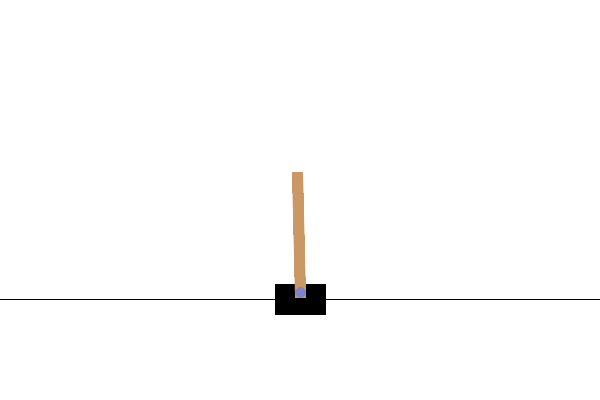

In [3]:
# Movie instance to capture the thing
movie = Movie()

# Inititalize environment
# observation is an array of four numbers [x, xdot, theta, thetadot]
observation, info = env.reset()
terminated = truncated = False
steps = 0

while not (terminated or truncated):
    # action: 0 = push cart left, 1 = push cart right
    action = 0
    
    # Take a step
    observation, reward, terminated, truncated, info = env.step(action)
    steps += 1

    # Add to movie
    movie.add_state(env)

print(f"run ended after {steps} out of a possible 500 steps")
movie.show()

This is less than impressive, so let's try to improve on that policy.

Try out the following

 1. first simply push the cart left whenever the pole is pointing
    left and right if the pole is pointing right. Observe that this
    results in an "increasing oscillating motion"

 2. we can improve on this by considering $\dot\theta$ rather than $\theta$.
    Observe that this results in the cart "running off" the field
    of play.


run ended after 163 out of a possible 500 steps


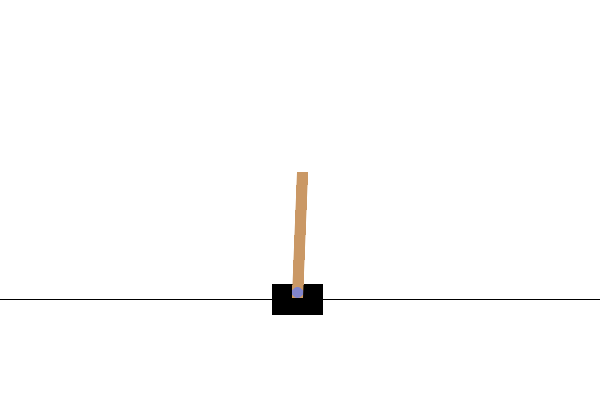

In [4]:
# Movie instance to capture the thing
movie = Movie()

# Inititalize environment
# observation is an array of four numbers [x, xdot, theta, thetadot]
observation, info = env.reset()
terminated = truncated = False
steps = 0

while not (terminated or truncated):
    # action: 0 = push cart left, 1 = push cart right        
    action = 0 if observation[3] < 0 else 1

    # Take a step
    observation, reward, terminated, truncated, info = env.step(action)
    steps += 1

    # Add to movie
    movie.add_state(env)
# print(observation, reward, terminated, truncated, info)
print(f"run ended after {steps} out of a possible 500 steps")

movie.show()

In [5]:
assert np.abs(observation[0]) > 2.4

Q-table learning
----------------
We are going to try to apply Q-table learning to the problem, and see whether the machine is 
able to generate a policy which keeps the pole stable.

Remember that Q learning works with a "quality" table $Q$, where $Q_{ao}$ is the expected return
(cumulative reward) when taking the action $a$ when observing $o$. Since, however, our observation
space is continuous, we cannot apply Q-learning directly, we must first **discretize** our space.

For this, we are going to write a function `obs_to_q_index`, which takes in an `observation`, i.e.,
a list $x, \dot x, \theta, \dot\theta$, and returns an integer index $0, 1, ..., N-1$ we can use
to index the Q-table.

To do this, we try the following prescription, selected empirically. 
We only look at $\theta$ and $\dot\theta$:

 1. For $\theta$, the allowed range is about $[-0.42, 0.42]$ (radians, which corresponds to 24 degrees), 
   and we are going to split that into 6 equisized bins, i.e., we choose $i = 0$ for
   $\theta \in [-0.42, -0.28)$, $i = 1$ for $\theta \in [-0.28, -0.14)$ and so on.
   
 2. For $\dot\theta$, the range is inifinite. We are going to use three bins: $j = 0$ for $\dot\theta < -0.29$,
    $j=1$ for $\dot\theta \in [-0.29, 0.29]$, and $j = 2$ for $\dot\theta > 0.29$.

Now the full index returned is then simply $3 i + j$.

In [6]:
def obs_to_q_index(observation):
    i = np.argmax(np.linspace(-0.42, 0.42, 6+1) > observation[2]) - 1
    j = 0 if observation[3] < -0.29 else 2 if observation[3] > 0.29 else 1
    
    return 3*i + j

In [7]:
assert obs_to_q_index(np.array([1.1, 0.3, 0.31, 0.17])) == 16
assert obs_to_q_index(np.array([1.8, 0.1, 0.0, -0.5])) == 9
assert obs_to_q_index(np.array([0.0, -1.0, -0.4, -1.0])) == 0


Next, let's create our Q table.  Make a new variable `q_table` with the
suitable dimension for the problem and fill it with zeros:

In [8]:
# 3*max(i) + max(j) + 1 possible observations
# 2 possible actions
q_table = np.zeros((3*5 + 2 + 1, 2))

In [9]:
assert np.abs(q_table).sum() == 0
assert hashlib.sha256(repr(q_table.shape).encode('utf-8')).hexdigest() == \
    '5acc3b7fb640f861cd6d6627410ca1ff9711fe15a0bac8f67c2e364e17538377', "wrong shape"

We need a policy (i.e., a function choosing an action for a given observation and exploration parameter $\epsilon$)
based on the values in the Q-table and some randomness.

Fill in this function such that it returns a suitable action:

In [10]:
rng = np.random.default_rng(4711)

def choose_action(observation, epsilon):
    global q_table
    
    # get obs index
    index = obs_to_q_index(observation)
    
    # get action corresponding to largest Q value in current obs row
    action = np.argmax(q_table[index, :])
    
    if np.random.rand() > epsilon:
        return action
    else:
        # select random action
        return np.random.choice(range(q_table.shape[1]))

In [11]:
assert choose_action(np.array([1.1, 0.3, -0.31, 0.17]), 0.1) in (0, 1)

q_table[16, :] = [0.2, 0.3]
assert choose_action(np.array([1.1, 0.3, 0.31, 0.17]), 0.0) == 1
q_table[10, :] = [0.5, -0.1]
assert choose_action(np.array([1.1, 0.3, 0.0, -0.1]), 0.0) == 0
q_table[16, :] = 0

We need one final function: a way to update the policy. For this, we are going to use
the [Bellmann equation]:
$$
Q_{oa} \gets (1-\eta) Q_{oa} + \eta (r + \gamma Q^*_{o'})
$$
where $o$ is the current observation, $a$ is the action, $o'$ is the next observation
after we have taken the action, $r$ is the reward, $\eta$ is the learning rate, and
$\gamma$ is the discount rate (which we fix to some high value).

[Bellmann equation]: https://en.wikipedia.org/wiki/Bellman_equation

In [12]:
gamma = 0.99
def update_q(action, obs, reward, next_obs, eta):
    global q_table, gamma
    
    index = obs_to_q_index(obs)
    next_index = obs_to_q_index(next_obs)
    
    q_table[index, action] = (1-eta) * q_table[index, action] + eta*(reward + gamma*max(q_table[next_index, :]))

We are finally ready to train!

In the code below, adapt the training loop from the beginning to use the
`choose_action` and `update_q` functions from above.  Note that in order
to update the Q table, you need access to the observation before and after
you've taken the step.

Note that it occasionally happen that the training fails even though you
did everything correctly. Simply run the cell two or three times to see
whether anything changes.

Training: ..........................................................................................................................................................................................
CartPole problem is solved after 185 eps.


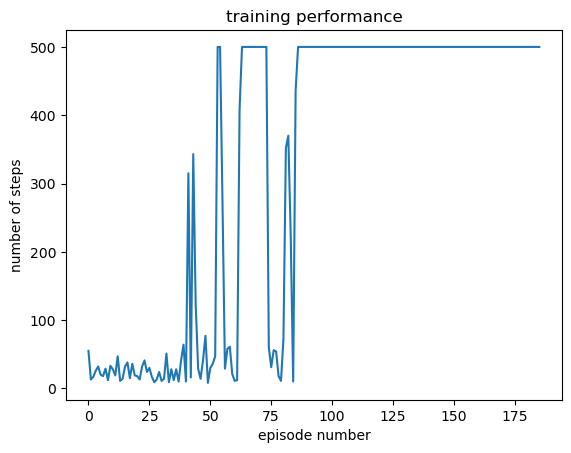

In [13]:
# Initializing the system
q_table[...] = 0
last_failure = 0
epsilon = 1.0
eta = 1.0
lengths = []

# Train the system
print("Training: ", end="")
for episode_no in range(1000):
    print(".", end="")
    # Learning rate and explore rate diminishes monotonically over time
    epsilon = max(0.01, 0.97 * epsilon)
    eta = max(0.01, 0.98 * eta)

    # (Re-)inititalize environment for each new episode
    observation, info = env.reset()
    terminated = truncated = False
    steps = 0
    
    # Loop for simulating a system once until done
    while not (terminated or truncated):
        # Choose action, take step, update policy:
        
        # choose action
        action = choose_action(observation, epsilon)
        # Take a step
        next_obs, reward, terminated, truncated, info = env.step(action)
        steps += 1
        
        # update Q table
        update_q(action, observation, reward, next_obs, eta)
            
        # update observation
        observation = next_obs

    # Add some diagnostics here
    lengths.append(steps)
    if steps < 500:
        last_failure = episode_no
    elif episode_no - last_failure >= 100:
        print(f'\nCartPole problem is solved after {episode_no} eps.')
        break

env.close()
pl.xlabel("episode number")
pl.ylabel("number of steps")
pl.title("training performance")
pl.plot(lengths)

Finally, let's see our trained cart in action:

Use the simulation code from the very beginning and adapt it such that we choose
the action based on the trained policy. (How should we choose `epsilon`?)

run ended after 500 out of a possible 500 steps


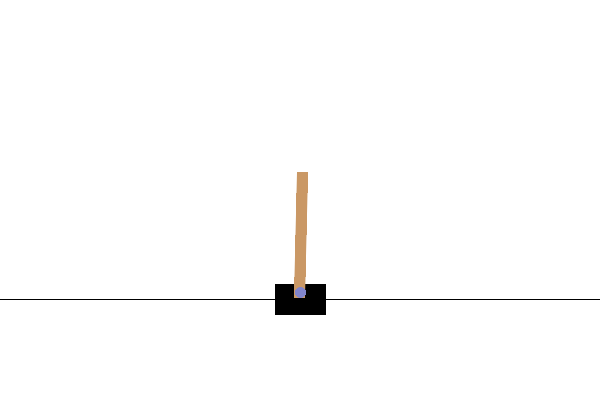

In [14]:
# Movie instance to capture the thing
movie = Movie()

# Inititalize environment
# observation is an array of four numbers [x, xdot, theta, thetadot]
observation, info = env.reset()
terminated = truncated = False
steps = 0

while not (terminated or truncated):
    
    # choose action
    # This time epsilon=0 because we already found the 'optimal' solution so no need
    # to further explore the space of possible actions. This was only needed for training
    action = choose_action(observation, epsilon=0)
    # Take a step
    observation, reward, terminated, truncated, info = env.step(action)
    steps += 1
        
    # Add to movie
    movie.add_state(env)

print(f"run ended after {steps} out of a possible 500 steps")
movie.show()